In [1]:
%load_ext autoreload
%autoreload 2

In [78]:
import os
import pdb
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from hyperopt import hp, tpe, fmin, Trials
from tqdm import tqdm

from collections import OrderedDict, defaultdict
import itertools
from functools import partial
import datetime
from joblib import Parallel, delayed
import copy

from data.dataloader import get_jhu_data, get_covid19india_api_data
from data.processing import get_district_time_series

from models.seir.seir_testing import SEIR_Testing
from main.seir.optimiser import Optimiser
from main.seir.losses import Loss_Calculator

In [155]:
def get_data(dataframes, state, district, use_dataframe='districts_daily', disable_tracker=False, filename=None):
    if disable_tracker:
        df_district = pd.read_csv(filename)
        df_district['date'] = pd.to_datetime(df_district['date'])
        return df_district
    
    df_district = get_district_time_series(dataframes, state=state, district=district, use_dataframe=use_dataframe)
    return df_district

In [4]:
dataframes = get_covid19india_api_data()

In [33]:
state = 'Maharashtra'
district = 'Pune'
train_period=6
val_period=5
train_on_val=False

In [6]:
df_district = get_data(dataframes, state, district, use_dataframe='districts_daily')

/home/users/sansiddh/anaconda3/envs/covid/lib/python3.8/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [8]:
def train_val_split(df_district, train_rollingmean=False, val_rollingmean=False, val_size=5, which_columns = ['hospitalised', 'total_infected', 'deceased', 'recovered']):
    print("splitting data ..")
    df_true_fitting = copy.copy(df_district)
    for column in which_columns:
        df_true_fitting[column] = df_true_fitting[column].rolling(5, center=True).mean()
    
    df_true_fitting = df_true_fitting[np.logical_not(df_true_fitting['total_infected'].isna())]
    df_true_fitting.reset_index(inplace=True, drop=True)
    
    if train_rollingmean:
        if val_size == 0:
            df_train = pd.concat([df_true_fitting, df_district.iloc[-(val_size+2):, :]], ignore_index=True)
            return df_train, None, df_true_fitting
        else:
            df_train = pd.concat([df_true_fitting.iloc[:-val_size, :], df_district.iloc[-(val_size+2):-val_size, :]], ignore_index=True)   
    else:
        if val_size == 0:
            return df_district, None, df_true_fitting  
        else:
            df_train = df_district.iloc[:-val_size, :]
        
    if val_rollingmean:
        df_val = pd.concat([df_true_fitting.iloc[-(val_size-2):, :], df_district.iloc[-2:, :]], ignore_index=True)
    else:
        df_val = df_district.iloc[-val_size:, :]
    df_val.reset_index(inplace=True, drop=True)
    return df_train, df_val, df_true_fitting

In [9]:
df_train, df_val, df_true_fitting = train_val_split(df_district, train_rollingmean=False, val_rollingmean=False, val_size=5)

splitting data ..


In [10]:
df_val

,state,district,date,hospitalised,total_infected,deceased,recovered
0,Maharashtra,Pune,2020-04-30,912,1248,88,248
1,Maharashtra,Pune,2020-05-01,901,1248,99,248
2,Maharashtra,Pune,2020-05-02,952,1339,102,285
3,Maharashtra,Pune,2020-05-03,951,1396,106,339
4,Maharashtra,Pune,2020-05-04,951,1396,106,339


In [238]:
train_period=0
val_period=5
train_on_val=True

print('fitting to data with "train_on_val" set to {} ..'.format(train_on_val))
if not os.path.exists('./plots'):
    os.makedirs('./plots')

df_district_raw_data = get_data(dataframes, state=state, district=district, use_dataframe='raw_data')
df_district_raw_data = df_district_raw_data[df_district_raw_data['date'] <= '2020-03-25']
# Get train val split
df_train, df_val, df_true_fitting = train_val_split(df_district_raw_data, train_rollingmean=True, val_rollingmean=False, val_size=0, which_columns=['total_infected'])


print('train\n', df_train.tail())
print('val\n', df_val)

# Initialise Optimiser
optimiser = Optimiser()
# Get the fixed params
default_params = optimiser.init_default_params(df_train, N=9.43e6, init_infected=max(df_train.iloc[0, :]['total_infected'], 1), 
                                               start_date=df_train.iloc[0, :]['date'] - datetime.timedelta(days=4))

# Create searchspace of variable params
variable_param_ranges = {
    'R0' : hp.uniform('R0', 1.2, 3),
    'T_inc' : hp.uniform('T_inc', 4, 5),
    'T_inf' : hp.uniform('T_inf', 3, 4),
    'T_recov_severe' : hp.uniform('T_recov_severe', 9, 20),
    'P_severe' : hp.uniform('P_severe', 0.3, 0.9),
    'P_fatal' : hp.uniform('P_fatal', 0, 0.4),
    'intervention_amount' : hp.uniform('intervention_amount', 0, 1)
}

# Perform Bayesian Optimisation
total_days = (df_train.iloc[-1, :]['date'] - default_params['starting_date']).days + 1
best, trials = optimiser.bayes_opt(df_train, default_params, variable_param_ranges, method='rmse', num_evals=1000, 
                                   loss_indices=[-train_period, None], total_days=total_days,
                                   which_compartments=['total_infected'])
print('best parameters\n', best)

In [244]:
best['R0'] = 1.35
df_prediction = optimiser.solve(best, default_params, df_train)

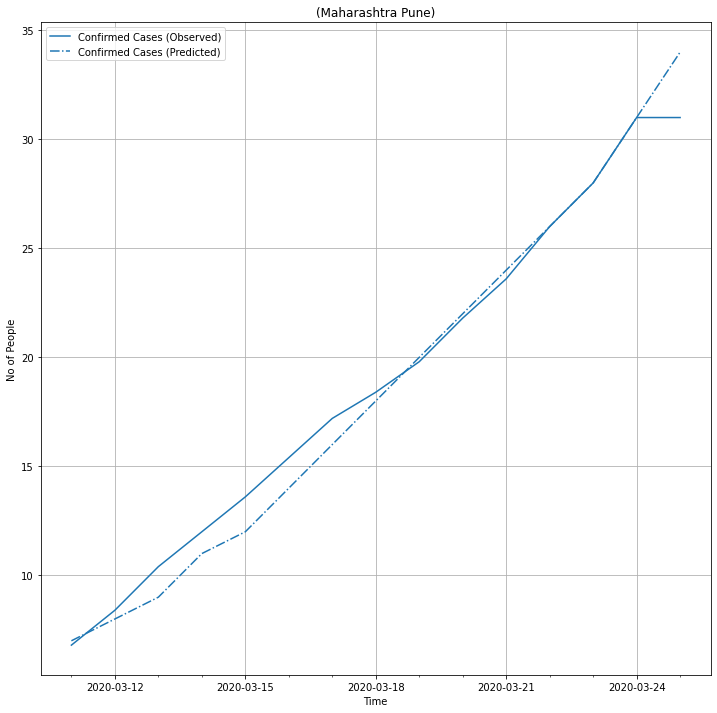

In [245]:
df_temp = df_prediction.loc[df_prediction['date'].isin(df_train['date']), ['date', 'hospitalised', 'total_infected', 'deceased', 'recovered']]

# Create plots
fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(df_train['date'], df_train['total_infected'], label='Confirmed Cases (Observed)')
ax.plot(df_train['date'], df_temp['total_infected'], '-.', color='C0', label='Confirmed Cases (Predicted)')
# ax.plot(df_district['date'], df_district['recovered'], label='Recovered Cases (Observed)')
# ax.plot(df_district['date'], df_temp['recovered'], 'g-.', label='Recovered Cases (Predicted)')
# ax.plot(df_district['date'], df_district['deceased'], label='Deceased Cases (Observed)')
# ax.plot(df_district['date'], df_temp['deceased'], 'r-.', label='Deceased Cases (Predicted)')
# ax.plot([df_train.iloc[-1, :]['date'], df_train.iloc[-1, :]['date']], [min(df_train['deceased']), max(df_train['total_infected'])], '--k', label='Train Test Boundary')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.ylabel('No of People')
plt.xlabel('Time')
plt.legend()
plt.title('({} {})'.format(state, district))
plt.grid()

In [246]:
predictions_dict = {}
predictions_dict['train0'] = {}
for name in ['best', 'default_params', 'optimiser', 'df_prediction', 'df_district_raw_data']:
    predictions_dict['train0'][name] = eval(name)

In [30]:
def fit_district(dataframes, state, district, train_period=10, val_period=5, train_on_val=False):
    print('fitting to data with "train_on_val" set to {} ..'.format(train_on_val))
    if not os.path.exists('./plots'):
        os.makedirs('./plots')

    df_district = get_data(dataframes, state=state, district=district, use_dataframe='districts_daily')
    df_district_raw_data = get_data(dataframes, state=state, district=district, use_dataframe='raw_data')
    if district is None:
        district = ''
        
    # Get train val split
    if train_on_val:
        df_train, df_val, df_true_fitting = train_val_split(df_district, val_rollingmean=False, val_size=0)
    else:
        df_train, df_val, df_true_fitting = train_val_split(df_district, val_rollingmean=False, val_size=val_period)

    print('train\n', df_train.tail())
    print('val\n', df_val)

    # Initialise Optimiser
    optimiser = Optimiser()
    # Get the fixed params
    default_params = optimiser.init_default_params(df_train, N=9.43e6, init_infected=max(df_district_raw_data.iloc[0, :]['total_infected'], 1), 
                                                   start_date=df_district_raw_data.iloc[0, :]['date'])

    # Create searchspace of variable params
    variable_param_ranges = {
        'R0' : hp.uniform('R0', 1.6, 5),
        'T_inc' : hp.uniform('T_inc', 4, 5),
        'T_inf' : hp.uniform('T_inf', 3, 4),
        'T_recov_severe' : hp.uniform('T_recov_severe', 9, 20),
        'P_severe' : hp.uniform('P_severe', 0.3, 0.9),
        'P_fatal' : hp.uniform('P_fatal', 0, 0.4),
        'intervention_amount' : hp.uniform('intervention_amount', 0, 1)
    }
    
    # Perform Bayesian Optimisation
    total_days = (df_train.iloc[-1, :]['date'] - default_params['starting_date']).days + 1
#     best, trials = optimiser.bayes_opt(df_train, default_params, variable_param_ranges, method='mape', num_evals=1700, 
#                                        loss_indices=[-train_period, None], total_days=total_days,
#                                        which_compartments=['hospitalised', 'recovered', 'total_infected', 'deceased'])

    best = {'P_fatal': 0.308243272795907, 'P_severe': 0.6926766210502527, 'R0': 3.18018046978732, 'T_inc': 4.45061014519293, 'T_inf': 3.831632940008536, 'T_recov_severe': 10.071582372668244, 'intervention_amount': 0.5708355773446028}

    print('best parameters\n', best)
    
    # Get Predictions dataframe    
    import pdb; pdb.set_trace()
    df_prediction = optimiser.solve(best, default_params, df_train, end_date=df_val.iloc[-1, :]['date'])
    
    loss_calculator = Loss_Calculator()
    df_loss_numbers = pd.DataFrame(columns=['train', 'val'], index=['hospitalised', 'total_infected', 'deceased', 'recovered'])
    
    df_temp = df_prediction.loc[df_prediction['date'].isin(df_train['date']), ['date', 'hospitalised', 'total_infected', 'deceased', 'recovered']]
    df_temp.reset_index(inplace=True, drop=True)
    df_train.reset_index(inplace=True, drop=True)
    for compartment in df_loss_numbers.index:
        df_loss_numbers.loc[compartment, 'train'] = loss_calculator._calc_mape(np.array(df_train[compartment]), np.array(df_temp[compartment]))

    df_temp = df_prediction.loc[df_prediction['date'].isin(df_val['date']), ['date', 'hospitalised', 'total_infected', 'deceased', 'recovered']]
    df_temp.reset_index(inplace=True, drop=True)
    df_val.reset_index(inplace=True, drop=True)
    for compartment in df_loss_numbers.index:
        df_loss_numbers.loc[compartment, 'val'] = loss_calculator._calc_mape(np.array(df_val[compartment]), np.array(df_temp[compartment]))
        
    import pdb; pdb.set_trace()

    
#     # Create plots
#     fig, ax = plt.subplots(figsize=(12, 12))
#     ax.plot(df_district['date'], df_district['total_infected'], label='Confirmed Cases (Observed)')
#     ax.plot(df_true_fitting['date'], df_true_fitting['total_infected'], label='Confirmed Cases (Rolling Avg(5))')
#     if train_on_val:
#         ax.plot([df_train.iloc[-train_period, :]['date'], df_train.iloc[-train_period, :]['date']], [min(df_train['total_infected']), max(df_train['total_infected'])], '--r', label='Train Period Starts')
#     else:
#         ax.plot([df_train.iloc[-1, :]['date'], df_train.iloc[-1, :]['date']], [min(df_train['total_infected']), max(df_val['total_infected'])], '--r', label='Train Test Boundary')
#     ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
#     ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
#     ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
#     plt.ylabel('No of People')
#     plt.xlabel('Time')
#     plt.legend()
#     plt.title('Rolling Avg vs Observed ({} {})'.format(state, district))
#     plt.grid()
# #     plt.savefig('./plots/{}_observed_{}_{}.png'.format(now, state, district))

#     fig, ax = plt.subplots(figsize=(12, 12))
#     ax.plot(df_train['date'], df_train['total_infected'], color='orange', label='Confirmed Cases (Rolling Avg (5))')
#     ax.plot(df_prediction['date'], df_prediction['total_infected'], '-g', label='Confirmed Cases (Predicted)')
#     if train_on_val:
#         ax.plot([df_train.iloc[-train_period, :]['date'], df_train.iloc[-train_period, :]['date']], [min(df_train['total_infected']), max(df_train['total_infected'])], '--r', label='Train Period Starts')
#     else:
#         ax.plot([df_train.iloc[-1, :]['date'], df_train.iloc[-1, :]['date']], [min(df_train['total_infected']), max(df_val['total_infected'])], '--r', label='Train Test Boundary')
#     ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
#     ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
#     ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
#     plt.ylabel('No of People')
#     plt.xlabel('Time')
#     plt.legend()
#     plt.title('Total Confirmed Cases ({} {})'.format(state, district))
#     plt.grid()
#     fname = './plots/{}_predictions_{}_{}.png'.format(now, state, district)
#     plt.savefig(fname)
#     print("plot saved as {}".format(fname))
    
#     return best, default_params, optimiser, df_prediction, df_district

In [31]:
fit_district(dataframes, state, district, train_period=6, val_period=5, train_on_val=False)

fitting to data with "train_on_val" set to False ..


/home/users/sansiddh/anaconda3/envs/covid/lib/python3.8/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


splitting data ..
train
          state district       date hospitalised total_infected deceased  \
1  Maharashtra     Pune 2020-04-25          772           1030       73   
2  Maharashtra     Pune 2020-04-26          770           1052       76   
3  Maharashtra     Pune 2020-04-27          762           1052       80   
4  Maharashtra     Pune 2020-04-28          873           1174       80   
5  Maharashtra     Pune 2020-04-29          863           1192       85   

  recovered  
1       185  
2       206  
3       210  
4       221  
5       244  
val
          state district       date hospitalised total_infected deceased  \
0  Maharashtra     Pune 2020-04-30          912           1248       88   
1  Maharashtra     Pune 2020-05-01          901           1248       99   
2  Maharashtra     Pune 2020-05-02          952           1339      102   
3  Maharashtra     Pune 2020-05-03          951           1396      106   
4  Maharashtra     Pune 2020-05-04          951           13

(Pdb)  c


--Return--
> <ipython-input-30-fc2257d9dd3f>(49)fit_district()->None
-> df_prediction = optimiser.solve(best, default_params, df_train, end_date=df_val.iloc[-1, :]['date'])


(Pdb)  df_loss_numbers


                  train      val
hospitalised    8.21852  22.0283
total_infected  6.56886   20.223
deceased         6.3478  23.7875
recovered       4.31928  12.2668


(Pdb)  q


BdbQuit: 

In [267]:
train_period=6
val_period=5
train_on_val=False

print('fitting to data with "train_on_val" set to {} ..'.format(train_on_val))

df_district = get_data(dataframes, state=state, district=district, use_dataframe='districts_daily')
df_district = get_data(dataframes, state, district, disable_tracker=True, filename='../../data/data/pune_050520.csv')
if district is None:
    district = ''

# Get train val split
if train_on_val:
    df_train, df_val, df_true_fitting = train_val_split(df_district, val_rollingmean=False, val_size=0)
else:
    df_train, df_val, df_true_fitting = train_val_split(df_district, val_rollingmean=False, val_size=val_period)

    
print('train\n', df_train.tail())
print('val\n', df_val)

# Initialise Optimiser
optimiser = Optimiser()
# Get the fixed params
default_params = optimiser.init_default_params(df_train, N=9.43e6, init_infected=max(df_district_raw_data.iloc[0, :]['total_infected'], 1), 
                                               start_date=df_district_raw_data.iloc[0, :]['date'])

# Create searchspace of variable params
variable_param_ranges = {
    'R0' : hp.uniform('R0', 1.6, 5),
    'T_inc' : hp.uniform('T_inc', 4, 5),
    'T_inf' : hp.uniform('T_inf', 3, 4),
    'T_recov_severe' : hp.uniform('T_recov_severe', 9, 20),
    'P_severe' : hp.uniform('P_severe', 0.3, 0.9),
    'P_fatal' : hp.uniform('P_fatal', 0, 0.3),
    'intervention_amount' : hp.uniform('intervention_amount', 0, 1)
}

# Perform Bayesian Optimisation
total_days = (df_train.iloc[-1, :]['date'] - default_params['starting_date']).days + 1
best, trials = optimiser.bayes_opt(df_train, default_params, variable_param_ranges, method='mape', num_evals=1500, 
                                   loss_indices=[-train_period, None], total_days=total_days,
                                   which_compartments=['hospitalised', 'total_infected'])

fitting to data with "train_on_val" set to False ..
splitting data ..
train
          date  total_infected  hospitalised  recovered  deceased
13 2020-04-23             916           809          0         0
14 2020-04-24            1021           913          0         0
15 2020-04-25            1101           991          0         0
16 2020-04-26            1130          1020          0         0
17 2020-04-27            1130          1020          0         0
val
         date  total_infected  hospitalised  recovered  deceased
0 2020-04-28            1207          1097          0         0
1 2020-04-29            1277          1206          0         0
2 2020-04-30            1401          1208          0         0
3 2020-05-01            1538          1293          0         0
4 2020-05-02            1630          1383          0         0
  0%|          | 3/1500 [00:00<00:54, 27.46trial/s, best loss: 105.38736618582236]

/home/users/sansiddh/anaconda3/envs/covid/lib/python3.8/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


100%|██████████| 1500/1500 [01:27<00:00, 17.08trial/s, best loss: 17.244067211828195]


In [270]:
print('best parameters\n', best)

# Get Predictions dataframe
df_prediction = optimiser.solve(best, default_params, df_train, end_date=df_val.iloc[-1, :]['date'])

loss_calculator = Loss_Calculator()
df_loss_numbers = pd.DataFrame(columns=['train', 'val'], index=['hospitalised', 'total_infected', 'deceased', 'recovered'])

df_temp = df_prediction.loc[df_prediction['date'].isin(df_train['date']), ['date', 'hospitalised', 'total_infected', 'deceased', 'recovered']]
df_temp.reset_index(inplace=True, drop=True)
df_train.reset_index(inplace=True, drop=True)
for compartment in df_loss_numbers.index:
    df_loss_numbers.loc[compartment, 'train'] = loss_calculator._calc_mape(np.array(df_train[compartment]), np.array(df_temp[compartment]))

df_temp = df_prediction.loc[df_prediction['date'].isin(df_val['date']), ['date', 'hospitalised', 'total_infected', 'deceased', 'recovered']]
df_temp.reset_index(inplace=True, drop=True)
df_val.reset_index(inplace=True, drop=True)
for compartment in df_loss_numbers.index:
    df_loss_numbers.loc[compartment, 'val'] = loss_calculator._calc_mape(np.array(df_val[compartment]), np.array(df_temp[compartment]))

best parameters
 {'P_fatal': 0.20292263719243972, 'P_severe': 0.881698962313643, 'R0': 3.0206290707735137, 'T_inc': 4.322024643139852, 'T_inf': 3.7709047548579266, 'T_recov_severe': 16.00397912685406, 'intervention_amount': 0.6390702849508979}


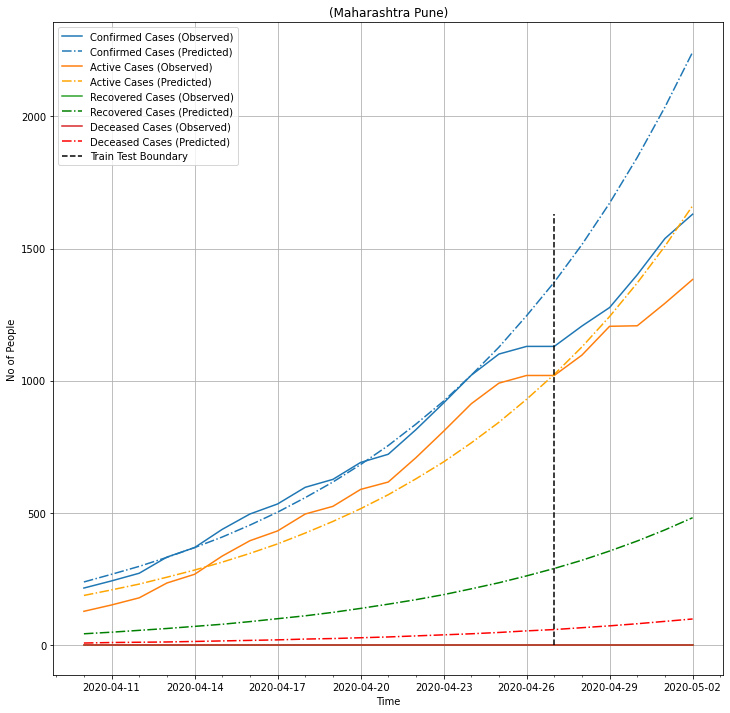

In [271]:
df_temp = df_prediction.loc[df_prediction['date'].isin(df_district['date']), ['date', 'hospitalised', 'total_infected', 'deceased', 'recovered']]

# Create plots
fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(df_district['date'], df_district['total_infected'], label='Confirmed Cases (Observed)')
ax.plot(df_district['date'], df_temp['total_infected'], '-.', color='C0', label='Confirmed Cases (Predicted)')
ax.plot(df_district['date'], df_district['hospitalised'], label='Active Cases (Observed)')
ax.plot(df_district['date'], df_temp['hospitalised'], '-.', color='orange', label='Active Cases (Predicted)')
ax.plot(df_district['date'], df_district['recovered'], label='Recovered Cases (Observed)')
ax.plot(df_district['date'], df_temp['recovered'], 'g-.', label='Recovered Cases (Predicted)')
ax.plot(df_district['date'], df_district['deceased'], label='Deceased Cases (Observed)')
ax.plot(df_district['date'], df_temp['deceased'], 'r-.', label='Deceased Cases (Predicted)')
ax.plot([df_train.iloc[-1, :]['date'], df_train.iloc[-1, :]['date']], [min(df_train['deceased']), max(df_val['total_infected'])], '--k', label='Train Test Boundary')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.ylabel('No of People')
plt.xlabel('Time')
plt.legend()
plt.title('({} {})'.format(state, district))
plt.grid()

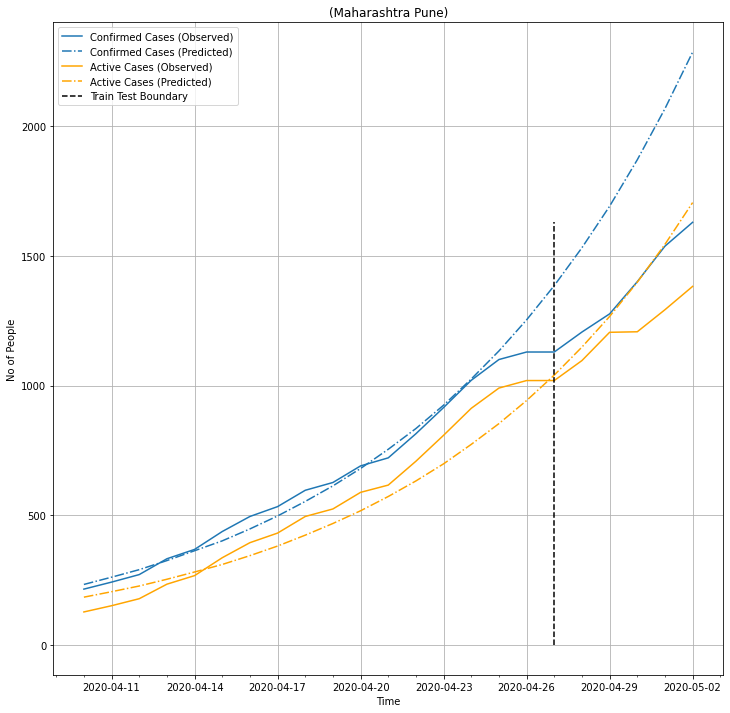

In [186]:
df_temp = df_prediction.loc[df_prediction['date'].isin(df_district['date']), ['date', 'hospitalised', 'total_infected', 'deceased', 'recovered']]

# Create plots
fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(df_district['date'], df_district['total_infected'], label='Confirmed Cases (Observed)')
ax.plot(df_district['date'], df_temp['total_infected'], '-.', color='C0', label='Confirmed Cases (Predicted)')
ax.plot(df_district['date'], df_district['hospitalised'], color='orange', label='Active Cases (Observed)')
ax.plot(df_district['date'], df_temp['hospitalised'], '-.', color='orange', label='Active Cases (Predicted)')
# ax.plot(df_district['date'], df_district['recovered'], label='Recovered Cases (Observed)')
# ax.plot(df_district['date'], df_temp['recovered'], 'g-.', label='Recovered Cases (Predicted)')
# ax.plot(df_district['date'], df_district['deceased'], label='Deceased Cases (Observed)')
# ax.plot(df_district['date'], df_temp['deceased'], 'r-.', label='Deceased Cases (Predicted)')
ax.plot([df_train.iloc[-1, :]['date'], df_train.iloc[-1, :]['date']], [min(df_train['deceased']), max(df_val['total_infected'])], '--k', label='Train Test Boundary')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.ylabel('No of People')
plt.xlabel('Time')
plt.legend()
plt.title('({} {})'.format(state, district))
plt.grid()

In [272]:
predictions_dict['train1'] = {}
for name in ['best', 'default_params', 'optimiser', 'df_prediction', 'df_district']:
    predictions_dict['train1'][name] = eval(name)

In [273]:
df_loss_numbers

,train,val
hospitalised,14.3342,9.73017
total_infected,5.40112,23.9543
deceased,100,100
recovered,100,100


In [131]:
df_loss_numbers.to_csv('loss.csv')

In [281]:
train_period=5
val_period=5
train_on_val=True
print('fitting to data with "train_on_val" set to {} ..'.format(train_on_val))

df_district = get_data(dataframes, state=state, district=district, use_dataframe='districts_daily')
df_district = get_data(dataframes, state, district, disable_tracker=True, filename='../../data/data/pune_050520.csv')
df_district_raw_data = get_data(dataframes, state=state, district=district, use_dataframe='raw_data')

if district is None:
    district = ''

# Get train val split
if train_on_val:
    df_train, df_val, df_true_fitting = train_val_split(df_district, val_rollingmean=False, val_size=0)
else:
    df_train, df_val, df_true_fitting = train_val_split(df_district, val_rollingmean=False, val_size=val_period)
    
print('train\n', df_train.tail())
print('val\n', df_val)

# Initialise Optimiser
optimiser = Optimiser()
# Get the fixed params
default_params = optimiser.init_default_params(df_train, N=9.43e6, init_infected=max(df_district_raw_data.iloc[0, :]['total_infected'], 1), 
                                               start_date=df_district_raw_data.iloc[0, :]['date'])

# Create searchspace of variable params
variable_param_ranges = {
    'R0' : hp.uniform('R0', 1.6, 5),
    'T_inc' : hp.uniform('T_inc', 4, 5),
    'T_inf' : hp.uniform('T_inf', 3, 4),
    'T_recov_severe' : hp.uniform('T_recov_severe', 9, 20),
    'P_severe' : hp.uniform('P_severe', 0.3, 0.9),
    'P_fatal' : hp.uniform('P_fatal', 0, 0.3),
    'intervention_amount' : hp.uniform('intervention_amount', 0, 1)
}

# Perform Bayesian Optimisation
total_days = (df_train.iloc[-1, :]['date'] - default_params['starting_date']).days + 1
best, trials = optimiser.bayes_opt(df_train, default_params, variable_param_ranges, method='mape', num_evals=1500, 
                                   loss_indices=[-train_period, None], total_days=total_days,
                                   which_compartments=['hospitalised', 'total_infected']) 

print('best parameters\n', best)

predictions_dict['train2'] = {}
for name in ['best', 'default_params', 'optimiser', 'df_prediction', 'df_district']:
    predictions_dict['train2'][name] = eval(name)

fitting to data with "train_on_val" set to True ..


/home/users/sansiddh/anaconda3/envs/covid/lib/python3.8/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


splitting data ..
train
          date  total_infected  hospitalised  recovered  deceased
18 2020-04-28            1207          1097          0         0
19 2020-04-29            1277          1206          0         0
20 2020-04-30            1401          1208          0         0
21 2020-05-01            1538          1293          0         0
22 2020-05-02            1630          1383          0         0
val
 None
100%|██████████| 1500/1500 [01:26<00:00, 17.28trial/s, best loss: 15.175712869284977]
best parameters
 {'P_fatal': 0.15758593661602738, 'P_severe': 0.8505965361335283, 'R0': 2.781207102718025, 'T_inc': 4.994842763581891, 'T_inf': 3.7358932342181, 'T_recov_severe': 11.301809586898106, 'intervention_amount': 0.8072435226387129}


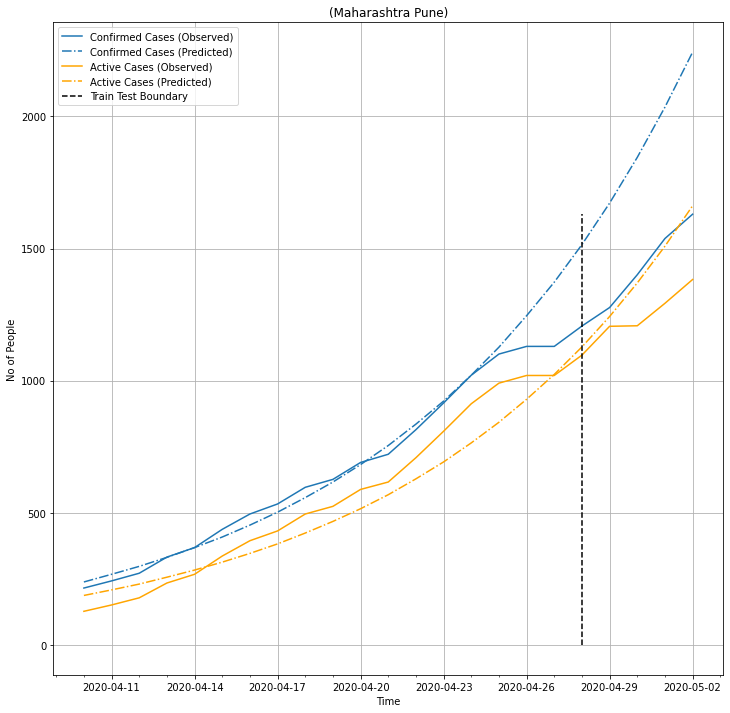

In [282]:
df_temp = df_prediction.loc[df_prediction['date'].isin(df_district['date']), ['date', 'hospitalised', 'total_infected', 'deceased', 'recovered']]

# Create plots
fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(df_district['date'], df_district['total_infected'], label='Confirmed Cases (Observed)')
ax.plot(df_district['date'], df_temp['total_infected'], '-.', color='C0', label='Confirmed Cases (Predicted)')
ax.plot(df_district['date'], df_district['hospitalised'], color='orange', label='Active Cases (Observed)')
ax.plot(df_district['date'], df_temp['hospitalised'], '-.', color='orange', label='Active Cases (Predicted)')
# ax.plot(df_district['date'], df_district['recovered'], label='Recovered Cases (Observed)')
# ax.plot(df_district['date'], df_temp['recovered'], 'g-.', label='Recovered Cases (Predicted)')
# ax.plot(df_district['date'], df_district['deceased'], label='Deceased Cases (Observed)')
# ax.plot(df_district['date'], df_temp['deceased'], 'r-.', label='Deceased Cases (Predicted)')
ax.plot([df_train.iloc[-train_period, :]['date'], df_train.iloc[-train_period, :]['date']], [min(df_train['deceased']), max(df_train['total_infected'])], '--k', label='Train Test Boundary')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.ylabel('No of People')
plt.xlabel('Time')
plt.legend()
plt.title('({} {})'.format(state, district))
plt.grid()

In [295]:
# simulate_till = datetime.strptime(end_date, '%Y-%m-%d')
simulate_till = datetime.datetime.today() + datetime.timedelta(days=30)

columns = ['forecastRunDate', 'regionType', 'region', 'model_name', 'error_function', 'error_value', 'current_total', 'current_active', 'current_recovered', 
       'current_deceased', 'current_hosptialized', 'current_icu', 'current_ventilator', 'predictionDate', 'active_mean', 'active_min', 
       'active_max', 'hospitalized_mean', 'hospitalized_min', 'hospitalized_max', 'icu_mean', 'icu_min', 'icu_max', 'deceased_mean', 
       'deceased_min', 'deceased_max', 'recovered_mean', 'recovered_min', 'recovered_max', 'total_mean', 'total_min', 'total_max']

df_output = pd.DataFrame(columns = columns)

best_params = copy.copy(predictions_dict['train2']['best'])
df_prediction = predictions_dict['train2']['optimiser'].solve(predictions_dict['train2']['best'], 
                                                              predictions_dict['train2']['default_params'], 
                                                              df_train, end_date=simulate_till)
prediction_daterange = df_prediction['date']
no_of_predictions = len(prediction_daterange)

df_output['predictionDate'] = prediction_daterange
df_output['forecastRunDate'] = [datetime.datetime.today().date()]*no_of_predictions

df_output['regionType'] = ['district']*no_of_predictions

df_output['model_name'] = ['SEIR']*no_of_predictions
df_output['error_function'] = ['MAPE']*no_of_predictions

error = [df_loss_numbers.loc['hospitalised', 'val']]

df_output['error_value'] = [error[0]]*no_of_predictions

pred_hospitalisations = df_prediction['hospitalised']
df_output['active_mean'] = pred_hospitalisations
df_output['active_min'] = (1 - 0.01*error[0])*pred_hospitalisations
df_output['active_max'] = (1 + 0.01*error[0])*pred_hospitalisations

df_output['hospitalized_mean'] = pred_hospitalisations
df_output['hospitalized_min'] = (1 - 0.01*error[0])*pred_hospitalisations
df_output['hospitalized_max'] = (1 - 0.01*error[0])*pred_hospitalisations

df_output['icu_mean'] = 0.02*pred_hospitalisations
df_output['icu_min'] = (1 - 0.01*error[0])*0.02*pred_hospitalisations
df_output['icu_max'] = (1 - 0.01*error[0])*0.02*pred_hospitalisations

pred_recoveries = df_prediction['recovered']
df_output['recovered_mean'] = pred_recoveries
df_output['recovered_min'] = (1 - 0.01*error[0])*pred_recoveries
df_output['recovered_max'] = (1 - 0.01*error[0])*pred_recoveries

pred_fatalities = df_prediction['deceased']
df_output['deceased_mean'] = pred_fatalities
df_output['deceased_min'] = (1 - 0.01*error[0])*pred_fatalities
df_output['deceased_max'] = (1 - 0.01*error[0])*pred_fatalities

pred_total_cases = pred_hospitalisations + pred_recoveries + pred_fatalities
df_output['total_mean'] = pred_total_cases
df_output['total_min'] = (1 - 0.01*error[0])*pred_total_cases
df_output['total_max'] = (1 - 0.01*error[0])*pred_total_cases

if state == 'Delhi':
    district = 'Delhi'
df_output['region'] = [district]*no_of_predictions

df_output.set_index('predictionDate', inplace=True)
df_district = predictions_dict['train2']['df_district']
df_output.loc[df_output.index.isin(df_district['date']), 'current_total'] = df_district['total_infected'].to_numpy()
df_output.loc[df_output.index.isin(df_district['date']), 'current_active'] = df_district['hospitalised'].to_numpy()
df_output.loc[df_output.index.isin(df_district['date']), 'current_recovered'] = df_district['recovered'].to_numpy()
df_output.loc[df_output.index.isin(df_district['date']), 'current_deceased'] = df_district['deceased'].to_numpy()
df_output.reset_index(inplace=True)
df_output = df_output[columns]

In [222]:
df_output.to_csv('output.csv')

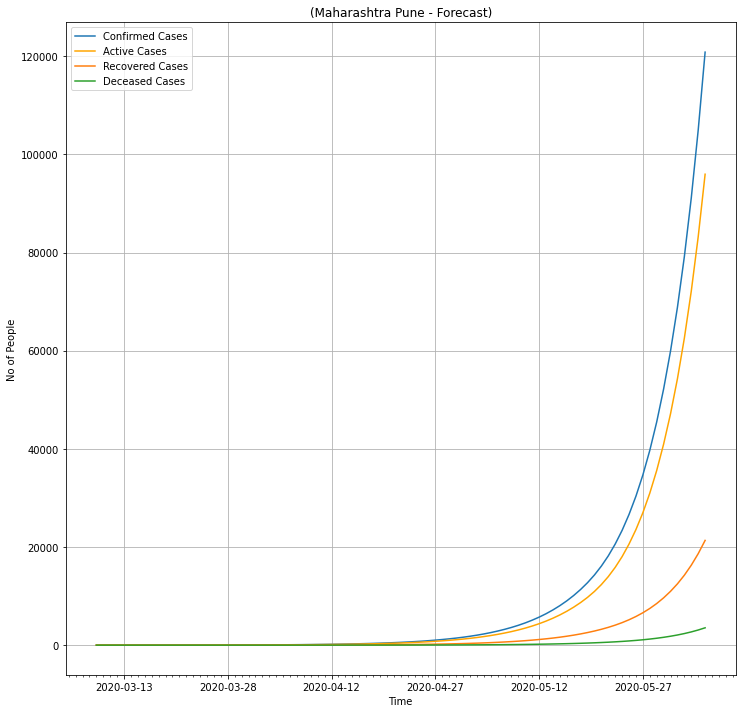

In [296]:
# Create plots
fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(df_output['predictionDate'], df_output['total_mean'], label='Confirmed Cases')
ax.plot(df_output['predictionDate'], df_output['active_mean'], color='orange', label='Active Cases')
ax.plot(df_output['predictionDate'], df_output['recovered_mean'], label='Recovered Cases')
ax.plot(df_output['predictionDate'], df_output['deceased_mean'], label='Deceased Cases')
# ax.plot(df_district['date'], df_district['total_infected'], '-.', color='C0', label='Deceased Cases (Obs)')
# ax.plot(df_district['date'], df_district['hospitalised'], '-.', color='orange', label='Deceased Cases (Obs)')
# ax.plot(df_district['date'], df_district['recovered'], 'g-.', label='Deceased Cases (Obs)')
# ax.plot(df_district['date'], df_district['deceased'], 'r-.', label='Deceased Cases (Obs)')
# ax.plot([df_train.iloc[-1, :]['date'], df_train.iloc[-1, :]['date']], [min(df_train['deceased']), max(df_val['total_infected'])], '--k', label='Train Test Boundary')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.ylabel('No of People')
plt.xlabel('Time')
plt.legend()
plt.title('({} {} - Forecast)'.format(state, district))
plt.grid()